Charge all requirement to load spark and spark context


In [1]:


from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Create a dataframe containing those data values then load it

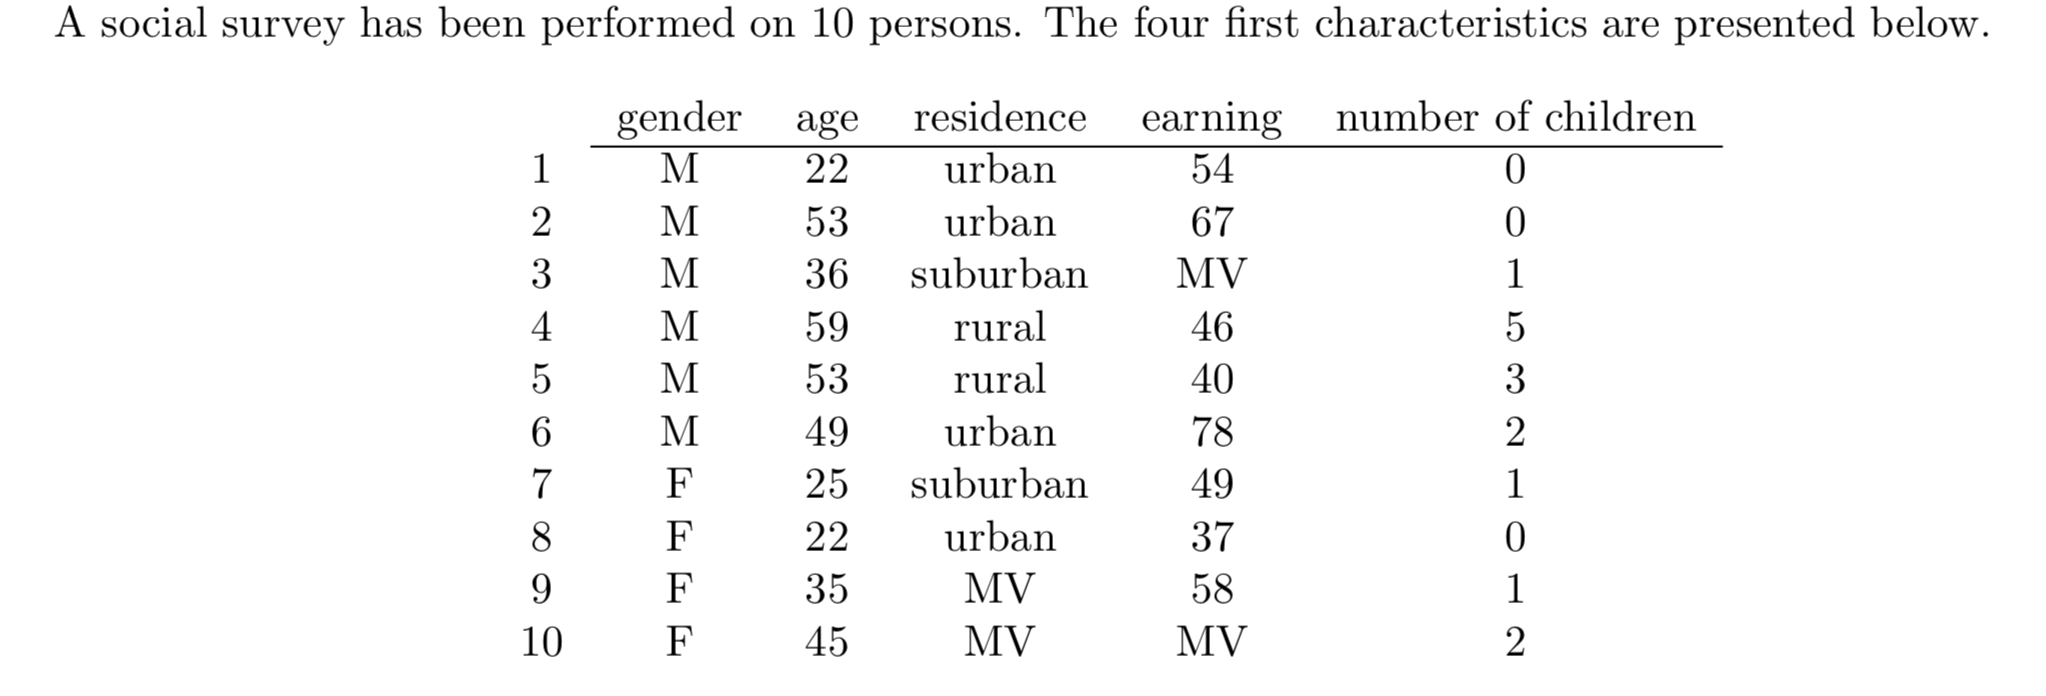

Before loading the data, add another row having all colunm missing

In [36]:
data = spark.read.csv("data/datapre.csv",header=True, inferSchema=True)

Show the data header then the print schema 

In [31]:
data.show()
data.printSchema()

+------+----+---------+-------+------------------+
|gender| age|residence|earning|number_of_children|
+------+----+---------+-------+------------------+
|     M|  22|    urban|     54|                 0|
|     M|  53|    urban|     67|                 0|
|     M|  36| suburban|     MV|                 1|
|     M|  59|    rural|     46|                 5|
|     M|  53|    rural|     40|                 3|
|     M|  49|    urban|     78|                 2|
|     F|  25| suburban|     49|                 1|
|     F|  22|    urban|     37|                 0|
|     F|  35|       MV|     58|                 1|
|     F|  45|       MV|     MV|                 2|
|  null|null|     null|   null|              null|
+------+----+---------+-------+------------------+

root
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- residence: string (nullable = true)
 |-- earning: string (nullable = true)
 |-- number_of_children: integer (nullable = true)



The earning feature is consider as string. In order to change it data format use the cast function and replace the MV(Missing value) by na values

In [37]:
# convert earning to double
from pyspark.sql.functions import col
data = data.withColumn("earning", col("earning").cast("double"))

data.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- residence: string (nullable = true)
 |-- earning: double (nullable = true)
 |-- number_of_children: integer (nullable = true)



In [38]:
# replace MV witn na values
from pyspark.sql.functions import when
data = data.withColumn("earning", when(col("earning") == "MV", None).otherwise(col("earning")))
data.show()

+------+----+---------+-------+------------------+
|gender| age|residence|earning|number_of_children|
+------+----+---------+-------+------------------+
|     M|  22|    urban|   54.0|                 0|
|     M|  53|    urban|   67.0|                 0|
|     M|  36| suburban|   null|                 1|
|     M|  59|    rural|   46.0|                 5|
|     M|  53|    rural|   40.0|                 3|
|     M|  49|    urban|   78.0|                 2|
|     F|  25| suburban|   49.0|                 1|
|     F|  22|    urban|   37.0|                 0|
|     F|  35|       MV|   58.0|                 1|
|     F|  45|       MV|   null|                 2|
|  null|null|     null|   null|              null|
+------+----+---------+-------+------------------+



Read the documentation about dropping missing values on spark https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.DataFrame.dropna.html

use the dropna using each time different value of "how" and "thresh" argument. 

In [23]:
# data.dropna(how="all").show()
# data.dropna(how="any").show()

# data.dropna(thresh=1).show()
data.dropna(thresh=2).show()

+------+---+---------+-------+------------------+
|gender|age|residence|earning|number_of_children|
+------+---+---------+-------+------------------+
|     M| 22|    urban|   54.0|                 0|
|     M| 53|    urban|   67.0|                 0|
|     M| 36| suburban|   null|                 1|
|     M| 59|    rural|   46.0|                 5|
|     M| 53|    rural|   40.0|                 3|
|     M| 49|    urban|   78.0|                 2|
|     F| 25| suburban|   49.0|                 1|
|     F| 22|    urban|   37.0|                 0|
|     F| 35|       MV|   58.0|                 1|
|     F| 45|       MV|   null|                 2|
+------+---+---------+-------+------------------+



What do you remark ?

We remark that when using the "any" value for the "how" argument, the row with all missing values is dropped. 

When using the "all" value for the "how" argument, the row with all missing values is not dropped. 

When using the "thresh" argument, the row with all missing values is dropped when the threshold is equal to 1. 

When using the "thresh" argument, the row with all missing values is not dropped when the threshold is equal to 2,3,4,5. 

...


Fill the missing values of the earning feature with the mean then the median and each time compute the standard deviation of this feature.

In [34]:
# fill earning na values with mean
from pyspark.sql.functions import mean, stddev

mean_val = data.select(mean(data["earning"])).collect()
mean_val = mean_val[0][0]
data = data.na.fill(mean_val, subset=["earning"])

# create a new column with standard deviation of earning
std_val = data.select(stddev(data["earning"])).collect()
std_val = std_val[0][0]
data = data.withColumn("std_earning", col("earning")/std_val)

data.show()

+------+----+---------+-------+------------------+------------------+
|gender| age|residence|earning|number_of_children|       std_earning|
+------+----+---------+-------+------------------+------------------+
|     M|  22|    urban|   54.0|                 0| 4.675587548152486|
|     M|  53|    urban|   67.0|                 0| 5.801191957892899|
|     M|  36| suburban| 53.625|                 1| 4.643118190179205|
|     M|  59|    rural|   46.0|                 5| 3.982907911389155|
|     M|  53|    rural|   40.0|                 3|3.4633981838166563|
|     M|  49|    urban|   78.0|                 2|  6.75362645844248|
|     F|  25| suburban|   49.0|                 1| 4.242662775175404|
|     F|  22|    urban|   37.0|                 0| 3.203643320030407|
|     F|  35|       MV|   58.0|                 1| 5.021927366534152|
|     F|  45|       MV| 53.625|                 2| 4.643118190179205|
|  null|null|     null| 53.625|              null| 4.643118190179205|
+------+----+-------

In [39]:
# fill earning na values with median
from pyspark.sql.functions import mean, stddev, col

median_val = data.approxQuantile("earning", [0.5], 0)
median_val = median_val[0]
data = data.na.fill(median_val, subset=["earning"])

# create a new column with standard deviation of earning
std_val = data.select(stddev(data["earning"])).collect()
std_val = std_val[0][0]
data = data.withColumn("std_earning", col("earning")/std_val)
data.show()


+------+----+---------+-------+------------------+------------------+
|gender| age|residence|earning|number_of_children|       std_earning|
+------+----+---------+-------+------------------+------------------+
|     M|  22|    urban|   54.0|                 0|   4.5958770797274|
|     M|  53|    urban|   67.0|                 0| 5.702291932254366|
|     M|  36| suburban|   49.0|                 1| 4.170332905678566|
|     M|  59|    rural|   46.0|                 5|3.9150064012492662|
|     M|  53|    rural|   40.0|                 3|3.4043533923906666|
|     M|  49|    urban|   78.0|                 2|   6.6384891151618|
|     F|  25| suburban|   49.0|                 1| 4.170332905678566|
|     F|  22|    urban|   37.0|                 0|3.1490268879613663|
|     F|  35|       MV|   58.0|                 1| 4.936312418966466|
|     F|  45|       MV|   49.0|                 2| 4.170332905678566|
|  null|null|     null|   49.0|              null| 4.170332905678566|
+------+----+-------